## Лабораторна робота 2 з ІСППР (варіант 22)
### Виконали студенти групи КІ-31мп Шабо О.А. та Сотник Д.C.
##### Датасет: https://www.kaggle.com/datasets/rahulsah06/gooogle-stock-pricedf_test.head()

In [1]:
import torch
import random
import gc
import os

import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import itertools as it

from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.optim import Adam

In [2]:
if torch.cuda.is_available():
    print("PyTorch GPU is available")
else:
    print("PyTorch GPU is not available")
DEVICE = "cuda"

PyTorch GPU is available


In [3]:
RANDOM_SEED = 10

# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(RANDOM_SEED)
# Set python seed
random.seed(RANDOM_SEED)
# Set numpy seed
np.random.seed(RANDOM_SEED)

torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(RANDOM_SEED)

In [4]:
df_train = pd.read_csv('/kaggle/input/gooogle-stock-price/Google_Stock_Price_Train.csv')
df_train.tail()

,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [6]:
df_test = pd.read_csv('/kaggle/input/gooogle-stock-price/Google_Stock_Price_Test.csv')
df_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [8]:
df_train['Close'] = pd.to_numeric(df_train['Close'].str.replace(',', ''), errors='coerce')
df = pd.concat([df_train, df_test], axis=0)

In [9]:
# Select features and target for modeling
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', ''), errors='coerce')

features = df[['Open', 'High', 'Low', 'Volume']]
target = df['Close'].to_frame()

# Normalize features
feature_scaler = StandardScaler()
target_scaler = deepcopy(feature_scaler)
split_index = int(len(df) * 0.25)
feature_scaler.fit(features.head(split_index)) # we have access only to train set
target_scaler.fit(target.head(split_index)) # we have access only to train set
features_normalized = feature_scaler.transform(features)
target_normalized = target_scaler.transform(target)

# Split the data
X_train = features_normalized[:split_index]
y_train = target_normalized[:split_index]
X_test = features_normalized[split_index:]
y_test = target_normalized[split_index:]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshaping for a single target
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [10]:
X_train_tensor.shape

torch.Size([319, 4])

In [11]:
y_train_tensor.shape

torch.Size([319, 1])

In [12]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [67]:
class BasicRNN():
    def fit(self, X_train, y_train, X_test, y_test, learning_rate=0.01,
            num_epochs=100, batch_size=32, verbose=True, optimizer_class=Adam,
            loss_fn=nn.MSELoss):
        optimizer = optimizer_class(self.parameters(), lr=learning_rate)
        criterion = loss_fn()

        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)

        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        train_losses = []
        test_losses = []

        for epoch in tqdm(range(num_epochs), disable=not verbose):
            self.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)

                optimizer.zero_grad()
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()  # Correct loss calculation
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

            test_loss = self.evaluate(test_loader, criterion)
            test_losses.append(test_loss)

            if verbose and (epoch+1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        self.train_losses = train_losses
        self.test_losses = test_losses
        gc.collect()

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.legend()
        plt.show()

    def plot_data_and_prediction(self, features_scaler, target_scaler,
                                 xticks_data=df['Date'].values,
                                 yticks_data=df['Close'].values,
                                 features_data=df.drop(['Date', 'Close'], axis=1),
                                 split_index=split_index
                                 ):
        _, ax = plt.subplots()
        # Plot real data
        ax.plot(xticks_data, yticks_data)
        
        # Plot predicted data
        y_pred = self.forward(
                torch.tensor(features_scaler.transform(features_data), dtype=torch.float32).to(DEVICE)\
            ).detach()

        y_pred_unscaled = target_scaler.inverse_transform(y_pred.cpu().numpy().reshape(-1, 1)).flatten()
    
        ax.plot(xticks_data, y_pred_unscaled, color='red', label='Prediction')
        plt.axvline(x=xticks_data[split_index], color='black', linestyle='--') # to identify train/test predictions
        
        # Modify x-axis ticks
        ax.set_xlabel("Date")
        ax.set_ylabel("Lowest Price")
        ax.set_title('Data and Prediction')
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        
        plt.show()

    def evaluate(self, data_loader, criterion):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)
                total_loss += loss.item()  # Correct loss calculation
        return total_loss / len(data_loader.dataset)
    

In [68]:
class RNNModel(nn.Module, BasicRNN):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_length):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.seq_length = seq_length

    def forward(self, x):
        # If there are only 2 dimensions, we add a seq_length dimension.
        # But, this might not be necessary depending on how your data is structured.
        if x.dim() == 2:
            x = x.unsqueeze(1)  # This can potentially misalign data if seq_length > 1.
        x = x.to(DEVICE)
        self.rnn.flatten_parameters() # to prevent raising warning
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Takes the output of the last sequence step
        return out

    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, seq_length, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, seq_length=seq_length).to(DEVICE)
            model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
            val_loss = model.evaluate(test_loader, criterion)

            if val_loss < best_loss:
                best_loss = val_loss
                best_params = params
                best_model = deepcopy(model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [69]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        self.lstm.flatten_parameters() # to prevent raising warning
        out, (hidden, cell) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, seq_length, batch_size = params
            input_dim = X_train.shape[-1]  
            output_dim = y_train.shape[-1] 
            
            model = LSTMDeepModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, seq_length=seq_length, num_layers=2).to(DEVICE)
            model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
            val_loss = model.evaluate(test_loader, criterion)

            if val_loss < best_loss:
                best_loss = val_loss
                best_params = params
                best_model = deepcopy(model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [70]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        self.gru.flatten_parameters() # to prevent raising warning
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

    @staticmethod
    def find_best_parameters(X_train, y_train, X_test, y_test, parameter_grid, criterion=nn.MSELoss()):
        best_loss = float('inf')
        best_params = None
        best_model = None

        for params in tqdm(list(it.product(*parameter_grid.values()))):
            lr, hidden_dim, seq_length, batch_size = params
            input_dim = X_train.shape[-1]
            output_dim = y_train.shape[-1]

            model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, seq_length=seq_length).to(DEVICE)
            model.fit(X_train, y_train, X_test, y_test, num_epochs=300, batch_size=batch_size, learning_rate=lr, verbose=False)

            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
            val_loss = model.evaluate(test_loader, criterion)

            if val_loss < best_loss:
                best_loss = val_loss
                best_params = params
                best_model = deepcopy(model)

        print(f'Best parameters found: {best_params}, with validation loss: {best_loss}')
        return best_params, best_model

In [71]:
parameter_grid = {
    'lr': [0.01],
    'hidden_dim': [100],
    'seq_length': [10],
    'batch_size': [64]
}

# parameter_grid = {
#     'lr': [0.1],
#     'hidden_dim': [25, 50, 75, 100],
#     'seq_length': [10, 20, 30],
#     'batch_size': [16, 32, 64, 128]
# }

(best_rnn_params, best_rnn_model) = RNNModel.find_best_parameters(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, parameter_grid)

  0%|          | 0/1 [00:00<?, ?it/s]

Best parameters found: (0.01, 100, 10, 64), with validation loss: 0.33265802478835343


In [72]:
# best_rnn_model.fit(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs=8000, learning_rate=best_rnn_params[0], batch_size=best_rnn_params[3])

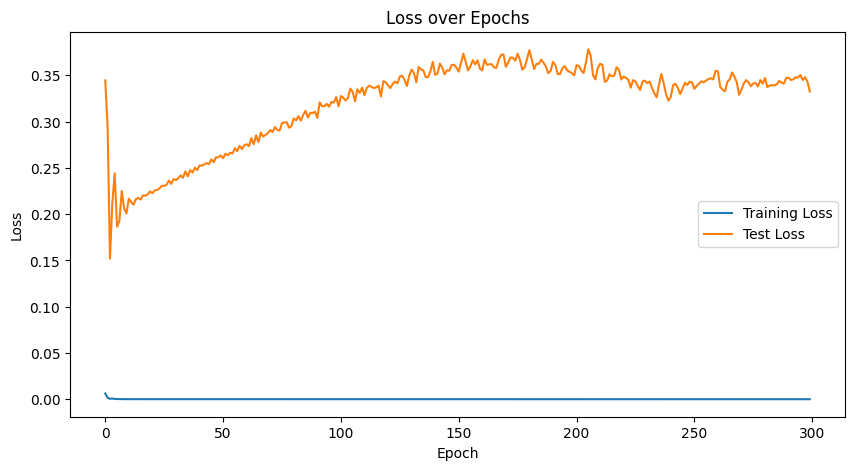

In [73]:
best_rnn_model.plot_loss()

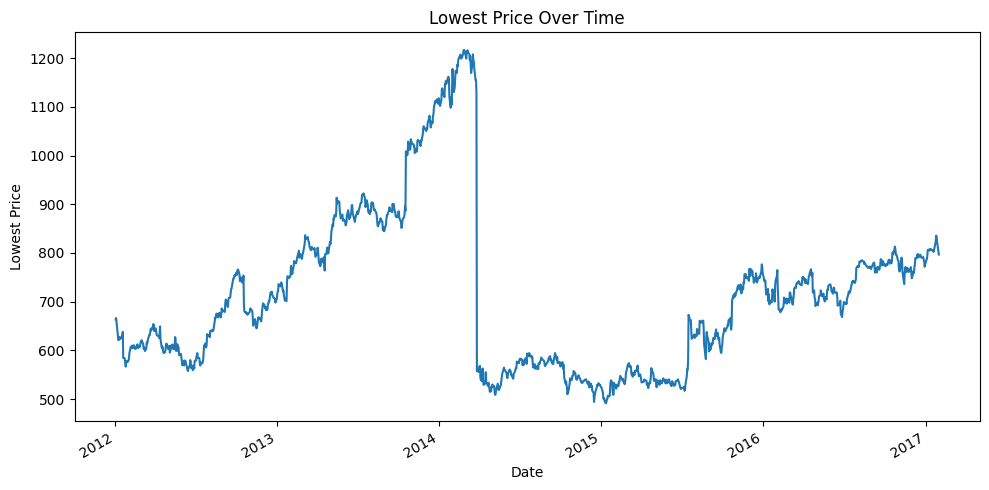

In [74]:
# Plot 'Avg' over time
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Lowest Price')
plt.xlabel("Date")
plt.ylabel("Lowest Price")
plt.title("Lowest Price Over Time")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

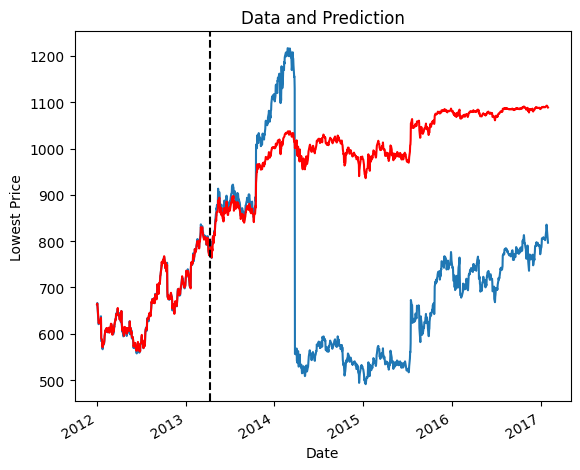

In [75]:
best_rnn_model.plot_data_and_prediction(feature_scaler, target_scaler)